- Consider a simple text corpus
- perform light weight cleaning
- form pairs of words
- input: word[0]    output: word[1]
- Fit neural network on above prepared data with 2 neurons in Hidden layer
- Idea is to represent each word in a pair of coordinates
- Implementation of W2V from scratch 

In [1]:
import pandas as pd
import numpy as np
import re
import tqdm
import os
import itertools
from scipy import sparse

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras import models, layers, Input, Model
from keras.models import Sequential
from keras.layers import Dense


2.10.0


Function to perform custom cleaning for the sample data


In [2]:
def get_vocabulary(text: list):
    text = sorted(text)
    unique_vocab = set(text)
    vocab_dict = {word:i for i, word in enumerate(sorted(unique_vocab))}
    print(vocab_dict)
    return vocab_dict

def text_preprocessing(
    text: list,
    punctuation = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
    stop_words = ['and', 'a', 'is', 'the', 'in', 'be', 'will', 'can', 'their']
) -> list:
    ''' Function to pre-process data '''
    
    #Replace the punctuations with none
    for char in text.lower():
        if char in punctuation:
            text = text.replace(char, '')
            
    #Remove words if they contain number
    '''
    The "\w" means "any word character" which usually means alphanumeric (letters, numbers, regardless of case) plus underscore (_)
    The "^" "anchors" to the beginning of a string, and the "$" "anchors" To the end of a string, which means that, 
    in this case, the match must start at the beginning of a string and end at the end of the string.
    '''
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Removing digits
    text = re.sub(r'[0-9]+', '', text)
    
    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text)
    
    #Lower case
    text = text.lower()
    
    #Convert each word to a list
    text = text.split()
    
    text = [word for word in text if word != '' and word not in stop_words]
    
    return text


In [3]:
texts = pd.read_csv('./input/sample.csv')
print(texts)

#Create the list
texts = [text for text in texts['text']]

                                                 text
0                       The future king is the prince
1                           Daughter is the princess 
2                                   Son is the prince
3                           Only a man can be a king 
4                         Only a woman can be a queen
5                        The princess will be a queen
6                       Queen and king rule the realm
7                          The prince is a strong man
8                  The princess is a beautiful woman 
9   The royal family is the king and queen and the...
10                           Prince is only a boy now
11                                A boy will be a man


In [17]:
# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

for text in texts:
    print(f"Before cleaning {text}")
    text = text_preprocessing(text)
    print(f"After cleaning {text}")
    
    # Appending to the all text list
    all_text += text 

    for i, word in enumerate(text):
        print(f"Index {i} -> word {word}")
        
        for w in range(window):
            
            if i + 1 + w < len(text):
                # Getting the context that is ahead by *window* words
                word_lists.append([word] + [text[i + 1 + w]])
                
            # Getting the context that is behind by *window* words    
            if i - w - 1 > 0:
                word_lists.append([word] + [text[i - w - 1]])
                
print(f"Number of pairs formed {len(word_lists)}")
print(f"Vocabulary with unique words {len(set(all_text))}")

unique_word_dict = get_vocabulary(all_text)

n_words = len(unique_word_dict)
words = unique_word_dict.keys()

print(f"unique words {words}")

#Create X & Y matrices
X, Y = [], []

for i, word_pair in enumerate(word_lists):
    print(f"Index {i} --> word paid {word_pair}")
    
    main_word_index    = unique_word_dict.get(word_pair[0])
    context_word_index = unique_word_dict.get(word_pair[1])
    
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)
    
    #One hot encode the indexes with 1 for the input and output word
    X_row[main_word_index]    = 1
    Y_row[context_word_index] = 1
    
    X.append(X_row)
    Y.append(Y_row)
    
print(X[0], Y[0])

# Converting the matrices into a sparse format because the vast majority of the data are 0s
X = sparse.csr_matrix(X)
Y = sparse.csr_matrix(Y)

# Defining the size of the embedding - cordinates to represent the word
embed_size = 2


inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer='adam')


# Optimizing the network weights
model.fit(
    x=X.todense(), 
    y=Y.todense(), 
    batch_size=256,
    epochs=1000
    )

weights = model.get_weights()[0]
print(weights)

embedding_dict = {}
for word in words:
    embedding_dict.update({
    word: weights[unique_word_dict.get(word)]
                    })
            

Before cleaning The future king is the prince
After cleaning ['future', 'king', 'prince']
Index 0 -> word future
Index 1 -> word king
Index 2 -> word prince
Before cleaning Daughter is the princess 
After cleaning ['daughter', 'princess']
Index 0 -> word daughter
Index 1 -> word princess
Before cleaning Son is the prince
After cleaning ['son', 'prince']
Index 0 -> word son
Index 1 -> word prince
Before cleaning Only a man can be a king 
After cleaning ['only', 'man', 'king']
Index 0 -> word only
Index 1 -> word man
Index 2 -> word king
Before cleaning Only a woman can be a queen
After cleaning ['only', 'woman', 'queen']
Index 0 -> word only
Index 1 -> word woman
Index 2 -> word queen
Before cleaning The princess will be a queen
After cleaning ['princess', 'queen']
Index 0 -> word princess
Index 1 -> word queen
Before cleaning Queen and king rule the realm
After cleaning ['queen', 'king', 'rule', 'realm']
Index 0 -> word queen
Index 1 -> word king
Index 2 -> word rule
Index 3 -> word re

The Sequence version uses the Sequencial model while the Model([inputs], [outputs]) uses the Functional API.

The first is easier to use, but only works for single-input single-output feed forward models (in the sense of Keras layers).

The second is more complex but get rid of those constraints, allowing to create many more models.

So, your main point is right: any sequencial model can be re-written as a functional model. You can double check this by comparing the architectures with the usage of summary function and plotting the models.

However, this only shows that architectures are the same, but not the weights!

Assuming you are fitting both models with same data and same compile and fit params (by the way, include those in your question), there is lots of randomness in the training process which may lead to different results.

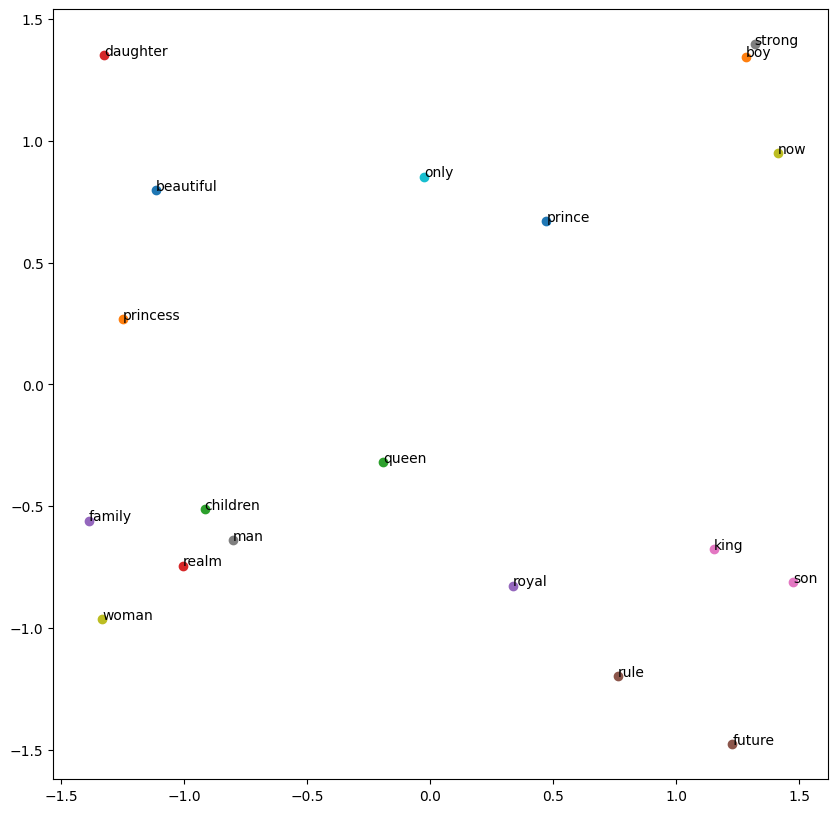

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for word in words:
    coordinates = embedding_dict.get(word)
    plt.scatter(coordinates[0], coordinates[1])
    plt.annotate(word, (coordinates[0], coordinates[1]))

Above plot shows the way the words are represented as weights(2 cooridnates)